In [1]:
""" pip install altair
pip install nbformat
pip install fanalysis """

' pip install altair\npip install nbformat\npip install fanalysis '

In [2]:
import pandas as pd
import geopandas as gpd 
import folium
from altair import Chart
from fanalysis.ca import CA
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%run 0-nettoyage-bdd-v2.ipynb

# Importation de la base de nbre de licenciés apres nettoyage

In [4]:
base=nettoyer_lic_comm("https://www.data.gouv.fr/fr/datasets/r/9b002e32-0ec9-40fc-9292-cddeae4416c6","https://www.insee.fr/fr/statistiques/fichier/4989724/ensemble.xlsx")

C:\Users\user\AppData\Local\Temp\ipykernel_22716\775948522.py:5: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  lic_comm = pd.read_csv(chemin_acces_lic_comm, encoding="utf-8", sep=";")



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   num_dep                  nom_dep  nombre_menages  nb_habitants   NBUC19  \
0       01                      Ain          265876        632800   425987   
1       02                    Aisne          223756        513384   351009   
2       03                   Allier          159016        326409   233659   
3       04  Alpes-de-Haute-Provence           74172        154335   109862   
4       05             Hautes-Alpes           64721        134710    95836   
..     ...                      ...             ...           ...      ...   
93      93        Seine-Saint-Denis          601846       1600460  1029621   
94      94             Val-de-Marne          565806       1363385   911777   
95      95               Val-d'Oise          466919       1256247   807878   
96     972               Martinique          149609        324588   227771   
97     974               La Réunion          323129        86810

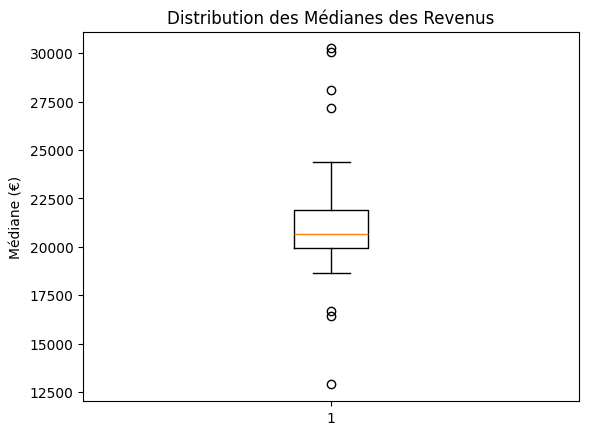

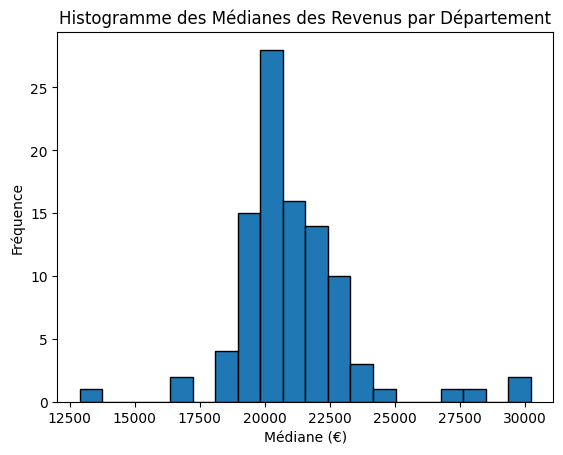

Le département avec le plus d'inégalités est : La Réunion
Corrélation entre revenu et inégalités: 0.12983021873638817
    num_dep                  nom_dep                      Région
0         1                      Ain        Auvergne-Rhône-Alpes
1         2                    Aisne             Hauts-de-France
2         3                   Allier        Auvergne-Rhône-Alpes
3         4  Alpes-de-Haute-Provence  Provence-Alpes-Côte d'Azur
4         5             Hautes-Alpes  Provence-Alpes-Côte d'Azur
..      ...                      ...                         ...
96      971               Guadeloupe                  Guadeloupe
97      972               Martinique                  Martinique
98      973                   Guyane                      Guyane
99      974               La Réunion                  La Réunion
100     976                  Mayotte                     Mayotte

[101 rows x 3 columns]


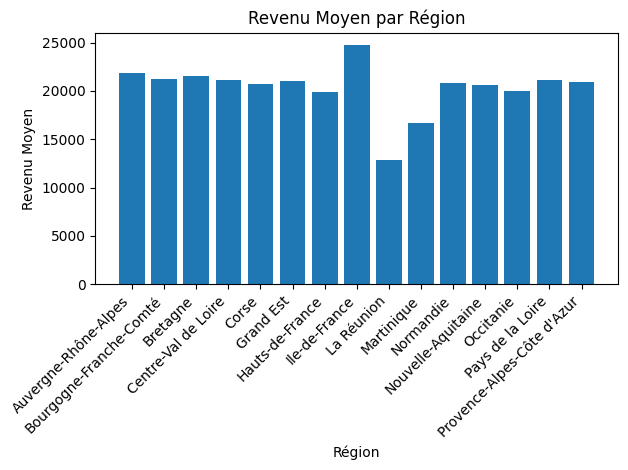

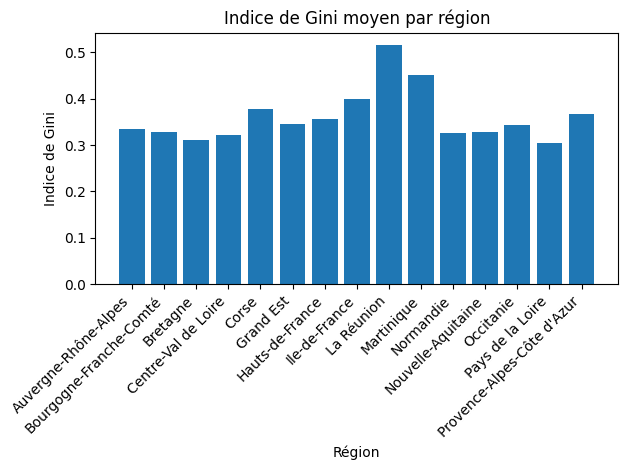

In [5]:
%run 2-analyse-base-revenus-departs.ipynb

#### Fonction pour l'analyse régionale####

In [6]:
#### taux de licenciés par régions
def base_region_et_proportion_licencies_region(base):
    base_region=base[["Région","nb_licencies"]].groupby('Région').sum().reset_index()
    pop_region=pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/4989724/ensemble.xlsx",sheet_name=0,skiprows=7)
    base_region=pd.merge(base_region,pop_region,left_on="Région", right_on="Nom de la région")
    base_region["taux_licencies"]=(base_region['nb_licencies']/base_region['Population municipale'])*100
    return base_region

In [10]:
def base_sport_par_region(base):
        #les sports plus pratiques par regions
    base_confondue=base[["Région",'Fédération',"nb_licencies"]].groupby(['Région','Fédération']).sum().reset_index()


    #les sports plus pratiqués par régions
    base_confondue=base[["Région",'Fédération',"nb_licencies"]].groupby(['Région','Fédération']).sum().reset_index()
    #On retire les fdérations qui ne précisent pas le sport pratiqué (UNSS, )
    base_confondue = base_confondue[(base_confondue["Fédération"]!= "FF Sports Pour Tous") &
                                    (base_confondue["Fédération"]!= "FF du Sport Universitaire") &
                                    (base_confondue["Fédération"]!= "F Sportive Educative de l'Enseignement Catholique (UGSEL)") &
                                    (base_confondue["Fédération"]!= "Union Française des Œuvres Laïques d'Éducation Physique (UFOLEP)") &
                                    (base_confondue["Fédération"]!= "Union Nationale du Sport Scolaire (UNSS)") &
                                    (base_confondue["Fédération"]!= "Union Sportive de l'Enseignement du Premier Degré ") &
                                    (base_confondue["Fédération"]!= "F Sportive et Gymnique du Travail") &
                                    (base_confondue["Fédération"]!= "FF de la Retraite Sportive")]


    #Hors UNSS 
    base_confondue = base_confondue[base_confondue['Fédération'] != "F Sportive Educative de l'Enseignement Catholique (UGSEL)"]
    base_confondue = base_confondue[base_confondue['Fédération'] != "Union Sportive de l'Enseignement du Premier Degré"]
    base_confondue = base_confondue[base_confondue['Fédération'] != "Union Nationale du Sport Scolaire (UNSS)"]
    return base_confondue 

In [7]:
#las 10 sports les plus pratriqués par régions.
def sports_plus_pratiques_par_region(base):
    #creation carte
    carte_france=folium.Map(location=[46.6031, 1.8883],tiles="OpenStreetMap", zoom_start=6)
    #importation shapefile
    reg_shape2=gpd.read_file("https://osm13.openstreetmap.fr/~cquest/openfla/export/regions-20180101-shp.zip")
        #creations des entroidespou les marqueurs
    reg_shape2['centroid']=reg_shape2.centroid
    #ajout des marqueurs
    for _, r in reg_shape2.iterrows():
            lat = r["centroid"].y
            lon = r["centroid"].x
            marker = folium.Marker(location=[lat, lon])
            popup = folium.Popup()
            if r['nom'] in ['Guyane','Mayotte','Guadeloupe','Martinique','La Réunion']: 
                nom_region='DROM'
            else: nom_region=r['nom']       
            data=base.loc[base['Région']==nom_region]
            data=data.sort_values(by = 'nb_licencies', ascending = False).head(10)
            #creation graphique à incorporer aux pop up
            bar_plot = (
                Chart(data)
                .mark_bar()
                .encode(
                    x="Fédération",
                    y="nb_licencies",
                    #color="Origin",
                )
            )
            vega_lite = folium.VegaLite(
            bar_plot,
            width="100%",
            height="100%",
            )
            vega_lite.add_to(popup)
            popup.add_to(marker)
            marker.add_to(carte_france)
  

    #aajouts des couches
    for _, r in reg_shape2.iterrows():
            # Without simplifying the representation of each borough,
            # the map might not be displayed
            sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
            folium.Popup(r["nom"]).add_to(geo_j)
            geo_j.add_to(carte_france)

    return carte_france

In [8]:
#les  sports   parmi les 5 les plus pratiqués dans les différentes régions
def sports_parmi_les_5_sports_plus_pratiques(base):
    list_region=base['Région'].unique()
    data=[]
    for region in list_region:
        top_5=base[base['Région']==region].sort_values(by='nb_licencies',ascending=False).head(5)['Fédération'].tolist()
        data.append(top_5)
    # Concaténation des sous-listes en une seule liste
    federations_concatenees = [federation for sublist in data for federation in sublist]

    # Obtention des valeurs uniques
    top_5= list(set(federations_concatenees))
    return top_5

In [20]:
# répartiton du sport par région 
def fonction_base_pivot(base):
    base_pivot_pivot=pd.pivot_table(base, values='nb_licencies', index='Région', columns='Fédération', fill_value=0)
    base_pivot_pivot=base_pivot_pivot.reset_index()
    base_pivot_pivot=base_pivot_pivot.rename_axis(None, axis=1).reset_index(drop=True)
    return base_pivot

In [17]:
""" # répartiton du sport par région pour un sexe 
def fonction_base_pivot_sexe(base,sexe):
    base_pivot=base[base['sexe']==sexe]
    base_pivot[["Région",'Fédération',"nb_licencies"]].groupby(['Région','Fédération']).sum().reset_index()
    base_pivot_pivot=pd.pivot_table(base_pivot, values='nb_licencies', index='Région', columns='Fédération', fill_value=0)
    base_pivot_pivot=base_pivot_pivot.reset_index()
    base_pivot_pivot=base_pivot_pivot.rename_axis(None, axis=1).reset_index(drop=True)
    return base_pivot """

' # répartiton du sport par région pour un sexe \ndef fonction_base_pivot_sexe(base,sexe):\n    base_pivot=base[base[\'sexe\']==sexe]\n    base_pivot[["Région",\'Fédération\',"nb_licencies"]].groupby([\'Région\',\'Fédération\']).sum().reset_index()\n    base_pivot_pivot=pd.pivot_table(base_pivot, values=\'nb_licencies\', index=\'Région\', columns=\'Fédération\', fill_value=0)\n    base_pivot_pivot=base_pivot_pivot.reset_index()\n    base_pivot_pivot=base_pivot_pivot.rename_axis(None, axis=1).reset_index(drop=True)\n    return base_pivot '

In [21]:
#creation de la base pour classification unquement avec les sports qui figurent parmi les 5 plus pratiqués 
def Base_classification_top5(base):
    top_5=sports_parmi_les_5_sports_plus_pratiques(base)
    base_pivot_general=fonction_base_pivot(base)
    base_afc=base_pivot_general[["Région"]+top_5]
    return base_afc